這段程式碼會讀取檔案，執行 JJA 篩選，並列印出 .npz 檔案裡面的變數名稱（因為我們需要知道裡面存了什麼 key），最後畫一張 JJA 的平均圖來確認。

正在讀取 NetCDF 檔案...
偵測到的時間變數名稱為: time
正在篩選 JJA (6, 7, 8月) 資料...
原始資料時間長度: 15706
JJA 資料時間長度: 3956

正在讀取 NPZ 檔案...
NPZ 檔案中包含的變數 (Keys): ['pcs_z_profile', 'EOF_z_profile', 'explained_z_profile', 'pcs_z_nolowpass_profile', 'EOF_z_nolowpass_profile', 'explained_z_nolowpass_profile', 'pcs_z_profile_total', 'pcs_z_nolowpass_profile_total', 'EOF_z_profile_4plot', 'plevels_interp', 'z_profile_0weight_reg2pc', 'z_profile_4plot_0weight_reg2pc', 'z_profile_0weight_reg2pc_reg', 'z_profile_4plot_0weight_reg2pc_reg', 'NPSH_index', 'NPSH_index_total', 'NPSH_index_nolowpass', 'NPSH_index_nolowpass_total']
正在繪製 z 的 JJA 平均圖...


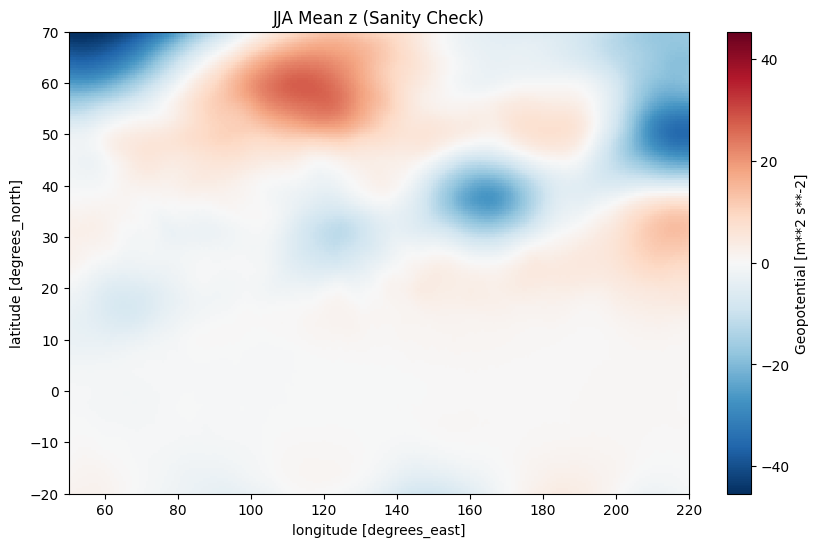

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案路徑
nc_file_path = "data/subset_50E_220E_-20_70-001.nc"
npz_file_path = "data/EOF_z_JJA_20to30N_profile_eddy.npz"

# ==========================================
# 1. 讀取 NetCDF 檔案 (Z500 高度場)
# ==========================================
print("正在讀取 NetCDF 檔案...")
ds = xr.open_dataset(nc_file_path)

# 自動偵測時間變數名稱 (通常是 'time'，但有時會不同)
# 我們尋找具有 datetime 屬性的座標
time_name = None
for coord in ds.coords:
    if np.issubdtype(ds[coord].dtype, np.datetime64) or ds[coord].attrs.get('standard_name') == 'time':
        time_name = coord
        break

if time_name is None:
    # 如果找不到，預設嘗試 'time'，這通常會報錯如果檔案結構特殊
    time_name = 'time' 

print(f"偵測到的時間變數名稱為: {time_name}")

# ==========================================
# 2. 篩選 JJA (6, 7, 8 月)
# ==========================================
# 教學解釋：這裡使用 .dt.month 提取月份，並用 isin 創造一個 Boolean Mask (布林遮罩)
# 這在矩陣運算中相當於把不符合條件的時間點設為 False 並剔除
print("正在篩選 JJA (6, 7, 8月) 資料...")
ds_jja = ds.sel({time_name: ds[time_name].dt.month.isin([6, 7, 8])})

# 檢查篩選後的維度
print(f"原始資料時間長度: {len(ds[time_name])}")
print(f"JJA 資料時間長度: {len(ds_jja[time_name])}")

# ==========================================
# 3. 讀取 NPZ 檔案 (WNPSH Index 或 EOF 相關)
# ==========================================
print("\n正在讀取 NPZ 檔案...")
data_npz = np.load(npz_file_path)

# 列出 npz 檔案中所有的 keys (變數名稱)
# 這一步很重要，我們需要確認裡面哪個變數是 'WNPSH index'
print("NPZ 檔案中包含的變數 (Keys):", data_npz.files)

# ==========================================
# 4. 視覺化檢查 (Sanity Check)
# ==========================================
# 我們畫出 JJA 的 Z500 平均場，確認地圖輪廓和數值範圍是否合理
# Z500 的單位通常是位勢米 (gpm)，數值約在 5000-5900 之間
if 'z' in ds_jja:
    var_name = 'z'
elif 'hgt' in ds_jja:
    var_name = 'hgt'
else:
    # 假設第一個變數就是我們要的 (排除 lat/lon/time)
    var_name = list(ds_jja.data_vars)[0]

print(f"正在繪製 {var_name} 的 JJA 平均圖...")

plt.figure(figsize=(10, 6))
# 計算時間平均並繪圖
ds_jja[var_name].mean(dim=time_name).plot()
plt.title(f"JJA Mean {var_name} (Sanity Check)")
plt.show()

In [5]:
import numpy as np
import xarray as xr

# ==========================================
# 1. 處理 NPSH_index_total (時間對齊)
# ==========================================
print("--- 1. 處理 NPSH Index ---")

# 讀取原始 Index
full_index = data_npz['NPSH_index_total'][0,:]
print(f"原始 Index shape: {full_index.shape} (預期是全年的長度)")

# 製作 JJA 的 Boolean Mask
# 利用 ds (全資料) 的時間索引來製作 mask
# 請確保 'ds' 變數還在你的記憶體中 (即上一步讀取的原始 dataset)
# 如果不在，請重新執行讀取 ds 的那一行
time_mask = ds[time_name].dt.month.isin([6, 7, 8]).values

# 應用遮罩篩選
index_jja = full_index[time_mask]

# 檢查維度並修正 (去除多餘的維度 (N, 1) -> (N,))
if index_jja.ndim > 1:
    index_jja = index_jja.squeeze()

print(f"JJA Index shape:  {index_jja.shape} : (time,)")


# ==========================================
# 2. 處理 Z 場 (直接展平，無加權)
# ==========================================
print("\n--- 2. 處理 Z 場 (直接展平) ---")

# 這裡直接使用 ds_jja['z']，不做 weights 運算
z_raw = ds_jja['z']

# 展平 (Flattening)
# 將 lat 和 lon 合併成 'location' 維度
z_flat = z_raw.stack(location=('lat', 'lon'))

# 處理 NaN (缺失值)
# 移除含有 NaN 的「空間點」
z_flat_clean = z_flat.dropna(dim='location', how='any')

# 轉換成 Numpy Array (這是後續矩陣運算的主角 X)
X = z_flat_clean.values

# 取得空間維度的資訊 (給自己參考用)
n_time, n_space = X.shape

print(f"原始 Z shape (JJA): {ds_jja['z'].shape} : (time, lat, lon)")
print(f"展平後 X shape:     {X.shape} : (time, space_points)")
print(f"  -> 時間點 (T): {n_time}")
print(f"  -> 空間點 (M): {n_space}")

# ==========================================
# 3. 最終確認
# ==========================================
if n_time == index_jja.shape[0]:
    print("\n[成功] Z矩陣 與 Index 的時間長度一致！可以進行下一步。")
else:
    print(f"\n[錯誤] 時間長度不一致！ Z: {n_time}, Index: {index_jja.shape[0]}")
    # 簡單除錯建議
    print("提示：請檢查 ds 的長度是否與 full_index 的長度完全一樣。")

# 儲存座標資訊 (畫圖用)
lat_coords = z_flat_clean.lat.values
lon_coords = z_flat_clean.lon.values

--- 1. 處理 NPSH Index ---
原始 Index shape: (15706,) (預期是全年的長度)
JJA Index shape:  (3956,) : (time,)

--- 2. 處理 Z 場 (直接展平) ---
原始 Z shape (JJA): (3956, 180, 272) : (time, lat, lon)
展平後 X shape:     (3956, 48960) : (time, space_points)
  -> 時間點 (T): 3956
  -> 空間點 (M): 48960

[成功] Z矩陣 與 Index 的時間長度一致！可以進行下一步。


正在準備進行 SVD 分解 (提取前 10 個模態)...
資料已去平均 (Centering done). Shape: (3956, 48960)
正在計算 SVD (這可能需要幾秒鐘)...
SVD 計算完成！

[結果]
PCs shape:  (3956, 10)  : (time, modes) -> 這是之後要用來回歸的 x(t)
EOFs shape: (10, 48960) : (modes, space_points) -> 這是空間圖

--- 前 10 個模態的解釋變異度 (Explained Variance Ratio) ---
Mode 1: 10.34%
Mode 2: 10.01%
Mode 3: 8.72%
Mode 4: 7.54%
Mode 5: 7.47%
Mode 6: 6.44%
Mode 7: 4.80%
Mode 8: 3.74%
Mode 9: 3.58%
Mode 10: 2.92%
前 10 個模態累積解釋變異度: 65.55%


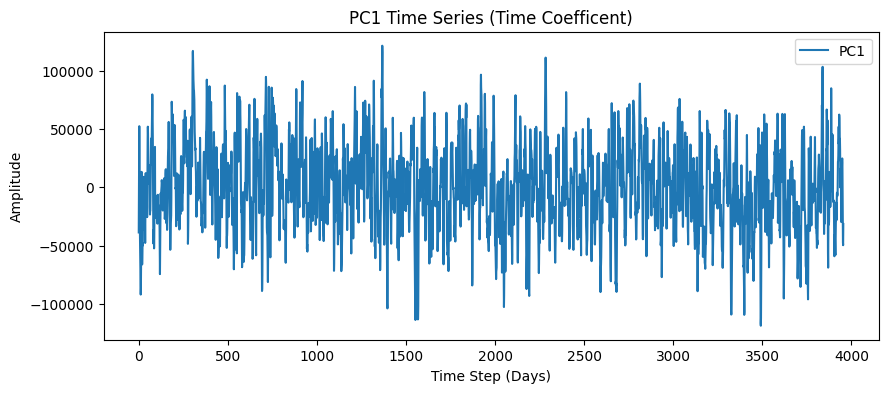

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 設定要提取的模式數量
n_modes = 10

print(f"正在準備進行 SVD 分解 (提取前 {n_modes} 個模態)...")

# ==========================================
# 1. 去平均 (Centering)
# ==========================================
# 計算每個空間點的時間平均
X_mean = np.mean(X, axis=0)
# 減去平均
X_anom = X - X_mean

print(f"資料已去平均 (Centering done). Shape: {X_anom.shape}")

# ==========================================
# 2. 執行 SVD (奇異值分解)
# ==========================================
# full_matrices=False 表示我們只計算前 min(M, N) 個模態，省記憶體
# U: 時間方向向量 (正規化過的)
# s: 奇異值 (Singular Values) -> 代表強度
# Vt: 空間方向向量 (EOFs)
print("正在計算 SVD (這可能需要幾秒鐘)...")
U, s, Vt = np.linalg.svd(X_anom, full_matrices=False)

print("SVD 計算完成！")

# ==========================================
# 3. 提取前 10 個 Modes
# ==========================================
# 提取奇異值
s_k = s[:n_modes]

# 提取 EOFs (空間圖)
# Vt 的形狀是 (n_modes, n_space_points)，所以直接切片前 10 列
EOFs = Vt[:n_modes, :]

# 提取 PCs (時間序列)
# PC = U * s (將強度乘回去，讓 PC 具有物理單位的量級)
# U 的形狀是 (n_time, n_modes)，切片前 10 行 (columns)
PCs = U[:, :n_modes] * s_k

print(f"\n[結果]")
print(f"PCs shape:  {PCs.shape}  : (time, modes) -> 這是之後要用來回歸的 x(t)")
print(f"EOFs shape: {EOFs.shape} : (modes, space_points) -> 這是空間圖")

# ==========================================
# 4. 計算解釋變異度 (Explained Variance)
# ==========================================
# 特徵值 = (奇異值^2) / (N-1)
eigenvalues = (s ** 2) / (X_anom.shape[0] - 1)

# 總變異數 (所有特徵值的和)
total_variance = np.sum(eigenvalues)

# 計算前 10 個 mode 的解釋比例
explained_variance_ratio = eigenvalues[:n_modes] / total_variance

# 印出結果
print("\n--- 前 10 個模態的解釋變異度 (Explained Variance Ratio) ---")
for i in range(n_modes):
    print(f"Mode {i+1}: {explained_variance_ratio[i]*100:.2f}%")

print(f"前 {n_modes} 個模態累積解釋變異度: {np.sum(explained_variance_ratio)*100:.2f}%")

# ==========================================
# 5. 簡單畫個圖確認 PC1
# ==========================================
# 畫出第一個 PC 的時間序列片段，看看是否合理
plt.figure(figsize=(10, 4))
plt.plot(PCs[:, 0], label='PC1')
plt.title('PC1 Time Series (Time Coefficent)')
plt.xlabel('Time Step (Days)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd

# 假設 PCs 已經在 workspace 中: shape (3956, 10)
# 假設 ds_jja 也在 workspace 中 (我們需要它的時間資訊)

print("正在構建線性動力算子 G...")

# 1. 準備時間標籤
# 確保它是 datetime64 格式以便計算天數差
times = ds_jja[time_name].values

# 2. 建立配對 (t, t+1)
# 我們需要找出所有 "今天" 和 "明天" 的 index
# X0: 今天, X1: 明天

# 初始化列表
valid_indices_t = []   # 今天的 index
valid_indices_tp1 = [] # 明天的 index (t plus 1)

# 迴圈檢查每一天 (雖然 Python 迴圈慢，但這裡只有 4000 筆，速度可以接受且邏輯最清晰)
# 或是使用向量化方法 (Vectorized approach) 比較快：
# 計算時間差
dt = times[1:] - times[:-1]
# 轉換為天數 (假設單位是 ns，這是 numpy 的預設)
one_day = np.timedelta64(1, 'D')

# 找出時間差正好是 1 天的位置 indices
# np.where 回傳的是 tuple，取 [0]
consecutive_indices = np.where(dt == one_day)[0]

print(f"總共有 {len(times)} 個時間點")
print(f"找到 {len(consecutive_indices)} 組連續的天數配對 (已排除跨年斷點)")

# 3. 建構 X0 和 X1 矩陣
# 注意：數學推導中我們習慣向量是 (M, 1)，所以矩陣是 (M, T)
# 但 Python 的 PCs 是 (T, M)，所以我們最後再轉置，或者直接用 Python 的寫法

# X0_series: 取出所有 "今天" 的 PCs
X0_series = PCs[consecutive_indices, :]  # Shape: (N_pairs, 10)

# X1_series: 取出對應的 "明天" 的 PCs
X1_series = PCs[consecutive_indices + 1, :] # Shape: (N_pairs, 10)

# 轉置成 (Modes, Time_steps) 以符合數學推導 G * x
X0 = X0_series.T  # Shape: (10, N_pairs)
X1 = X1_series.T  # Shape: (10, N_pairs)

print(f"用於回歸的矩陣形狀 X0: {X0.shape}")

# 4. 計算 G 矩陣
# 公式: G = (X1 * X0^T) * (X0 * X0^T)^-1

# 計算 C0 (共變異數矩陣) = X0 * X0^T
C0 = np.dot(X0, X0.T) 

# 計算 C1 (滯後共變異數矩陣) = X1 * X0^T
C1 = np.dot(X1, X0.T)

# 計算 C0 的反矩陣
C0_inv = np.linalg.inv(C0)

# 計算 G
G = np.dot(C1, C0_inv)

print("\n[結果]")
print(f"線性算子 G 計算完成。 Shape: {G.shape}")
print("G 的左上角 3x3 元素:")
print(G[:3, :3])

# 5. 檢查 G 的穩定性 (Stability Check)
# 計算 G 的特徵值。如果系統是穩定的，所有特徵值的絕對值應該 < 1 (或接近 1)
eigvals_G = np.linalg.eigvals(G)
max_eig_mag = np.max(np.abs(eigvals_G))

print(f"\nG 的最大特徵值模長 (Max eigenvalue magnitude): {max_eig_mag:.4f}")
if max_eig_mag < 1.0:
    print("系統是穩定的 (Stable) -> 擾動會隨時間衰減")
elif max_eig_mag > 1.0:
    print("系統是不穩定的 (Unstable) -> 擾動會隨時間無限放大 (這在大氣平均態附近不常見，可能是因為 sampling error)")
else:
    print("系統處於中性 (Neutral)")

正在構建線性動力算子 G...
總共有 3956 個時間點
找到 3913 組連續的天數配對 (已排除跨年斷點)
用於回歸的矩陣形狀 X0: (10, 3913)

[結果]
線性算子 G 計算完成。 Shape: (10, 10)
G 的左上角 3x3 元素:
[[ 0.91548526 -0.0351547  -0.06872332]
 [ 0.03390639  0.9344966   0.02403996]
 [ 0.07041841 -0.02381704  0.9219662 ]]

G 的最大特徵值模長 (Max eigenvalue magnitude): 0.9213
系統是穩定的 (Stable) -> 擾動會隨時間衰減


正在進行 Step 4: 投影到副熱帶高壓指數...

[結果]
回歸係數向量 a shape: (10,)
各個 PC 對 Index 的貢獻係數 (前5個):
  PC1: -0.0000
  PC2: -0.0000
  PC3: 0.0000
  PC4: -0.0000
  PC5: 0.0000
投影矩陣 rho shape: (10, 10)
rho 的對角線元素即為上述係數。

重建的 Index 與原始 Index 的相關係數: 0.3456


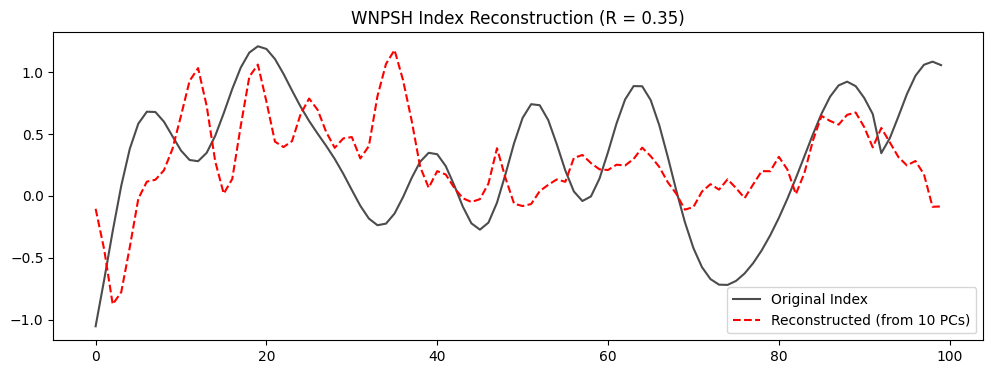

In [11]:
import numpy as np
import matplotlib.pyplot as plt

print("正在進行 Step 4: 投影到副熱帶高壓指數...")

# ==========================================
# 1. 準備資料
# ==========================================
# 確保維度匹配
# PCs: (3956, 10)
# index_jja: (3956,)
if PCs.shape[0] != index_jja.shape[0]:
    raise ValueError(f"維度不匹配! PCs: {PCs.shape}, Index: {index_jja.shape}")

# ==========================================
# 2. 執行線性回歸求解係數 a
# ==========================================
# index = PCs * a
# 使用 lstsq (Least Squares) 求解
# rcond=None 是為了兼容性，讓 numpy 自己決定 cutoff
solution = np.linalg.lstsq(PCs, index_jja, rcond=None)

# solution[0] 就是我們要的係數向量 a
coeffs_a = solution[0]

print("\n[結果]")
print(f"回歸係數向量 a shape: {coeffs_a.shape}")
print("各個 PC 對 Index 的貢獻係數 (前5個):")
for i in range(5):
    print(f"  PC{i+1}: {coeffs_a[i]:.4f}")

# ==========================================
# 3. 建構對角投影矩陣 rho
# ==========================================
rho = np.diag(coeffs_a)

print(f"投影矩陣 rho shape: {rho.shape}")
print("rho 的對角線元素即為上述係數。")

# ==========================================
# 4. 驗證效果 (Reconstruction Check)
# ==========================================
# 讓我們看看這 10 個 PC 能不能還原出原本的 Index
index_reconstructed = np.dot(PCs, coeffs_a)

# 計算相關係數 (Correlation)
correlation = np.corrcoef(index_jja, index_reconstructed)[0, 1]

print(f"\n重建的 Index 與原始 Index 的相關係數: {correlation:.4f}")

# 畫圖比較一下前 100 天
plt.figure(figsize=(12, 4))
plt.plot(index_jja[:100], label='Original Index', color='black', alpha=0.7)
plt.plot(index_reconstructed[:100], label='Reconstructed (from 10 PCs)', color='red', linestyle='--')
plt.title(f'WNPSH Index Reconstruction (R = {correlation:.2f})')
plt.legend()
plt.show()

## 看起來不太好 所以縮小區域

In [38]:
import numpy as np
import xarray as xr




# ==========================================
# 1. 重新篩選區域 (關鍵修正！)
# ==========================================
# 我們只取 lat 0 到 40 度，專注於副熱帶
# 注意：根據你的 nc 檔 lat 的排列 (是從小到大還是從大到小)，slice 的寫法可能不同
# 先檢查一下 lat 的順序，用 xarray 的 sel(lat=slice(min, max)) 通常會自動處理
print("正在縮小緯度範圍 (0N - 40N)...")

ds_subset = ds_jja.sel(lat=slice(0, 40)) # 或是 slice(10, 45) 也可以

# 檢查一下切完的形狀
print(f"切片後 Z shape: {ds_subset['z'].shape}")

# ==========================================
# 2. 重新製作 X 矩陣 (EOF Step)
# ==========================================
# 展平
lat_vals = ds_subset['z'].lat.values
# 廣播權重: sqrt(cos(lat))
weights = np.sqrt(np.cos(np.deg2rad(lat_vals)))
# 利用 xarray 的廣播機制，需要把 weights 轉成 DataArray
weights_da = xr.DataArray(weights, coords={'lat': lat_vals}, dims='lat')
z_flat_sub = (ds_subset['z']* weights_da).stack(location=('lat', 'lon'))
z_flat_sub = z_flat_sub.dropna(dim='location', how='any')

X_sub = z_flat_sub.values

# 去平均
X_sub_mean = np.mean(X_sub, axis=0)
X_sub_anom = (X_sub - X_sub_mean)/np.std(X_sub)

# SVD 分解
print("重新計算 SVD (Subtropical Domain)...")
U_sub, s_sub, Vt_sub = np.linalg.svd(X_sub_anom, full_matrices=False)

# 提取前 10 個模式
n_modes = 10
PCs_sub = U_sub[:, :n_modes] * s_sub[:n_modes]  # 包含振幅的 PCs
EOFs_sub = Vt_sub[:n_modes, :]

# ==========================================
# 3. 處理 Index (確保去平均)
# ==========================================
# 雖然之前檢查過似乎還好，但為了數學嚴謹：
index_clean = index_jja - np.mean(index_jja)
print(f"Index Mean removed. New mean: {np.mean(index_clean):.4e}")

# ==========================================
# 4. 重新計算 G (Linear Operator)
# ==========================================
# 找出連續時間點
times = ds_jja[time_name].values
dt = times[1:] - times[:-1]
one_day = np.timedelta64(1, 'D')
consecutive_indices = np.where(dt == one_day)[0]

# 構建 X0, X1
X0_series = PCs_sub[consecutive_indices, :]
X1_series = PCs_sub[consecutive_indices + 1, :]

X0 = X0_series.T
X1 = X1_series.T

# 計算 G (Method A: Pooled)
C0 = np.dot(X0, X0.T)
C1 = np.dot(X1, X0.T)
G_sub = np.dot(C1, np.linalg.inv(C0))

# 檢查 G 的穩定性
max_eig = np.max(np.abs(np.linalg.eigvals(G_sub)))
print(f"新 G 矩陣的最大特徵值: {max_eig:.4f}")

# ==========================================
# 5. 重新計算投影 (Projection)
# ==========================================
# 計算回歸係數 a
# index = PCs * a
solution = np.linalg.lstsq(PCs_sub, index_clean, rcond=None)
a_sub = solution[0]
rho_sub = np.diag(a_sub)

# 驗證相關係數
index_recon_sub = np.dot(PCs_sub, a_sub)
correlation_sub = np.corrcoef(index_clean, index_recon_sub)[0, 1]

print(f"\n[修正後結果]")
print(f"縮小區域後的相關係數 R: {correlation_sub:.4f}")
print(f"R^2 (解釋變異比例): {correlation_sub**2:.4f}")

if correlation_sub > 0.6:
    print("-> 相關性顯著提升！這表示新的 EOFs 抓到了副高的重點。")
else:
    print("-> 相關性仍然不高，可能需要檢查 Index 的定義或時間對齊。")

正在縮小緯度範圍 (0N - 40N)...
切片後 Z shape: (3956, 80, 208)
重新計算 SVD (Subtropical Domain)...
Index Mean removed. New mean: -7.1845e-18
新 G 矩陣的最大特徵值: 0.9098

[修正後結果]
縮小區域後的相關係數 R: 0.8547
R^2 (解釋變異比例): 0.7305
-> 相關性顯著提升！這表示新的 EOFs 抓到了副高的重點。


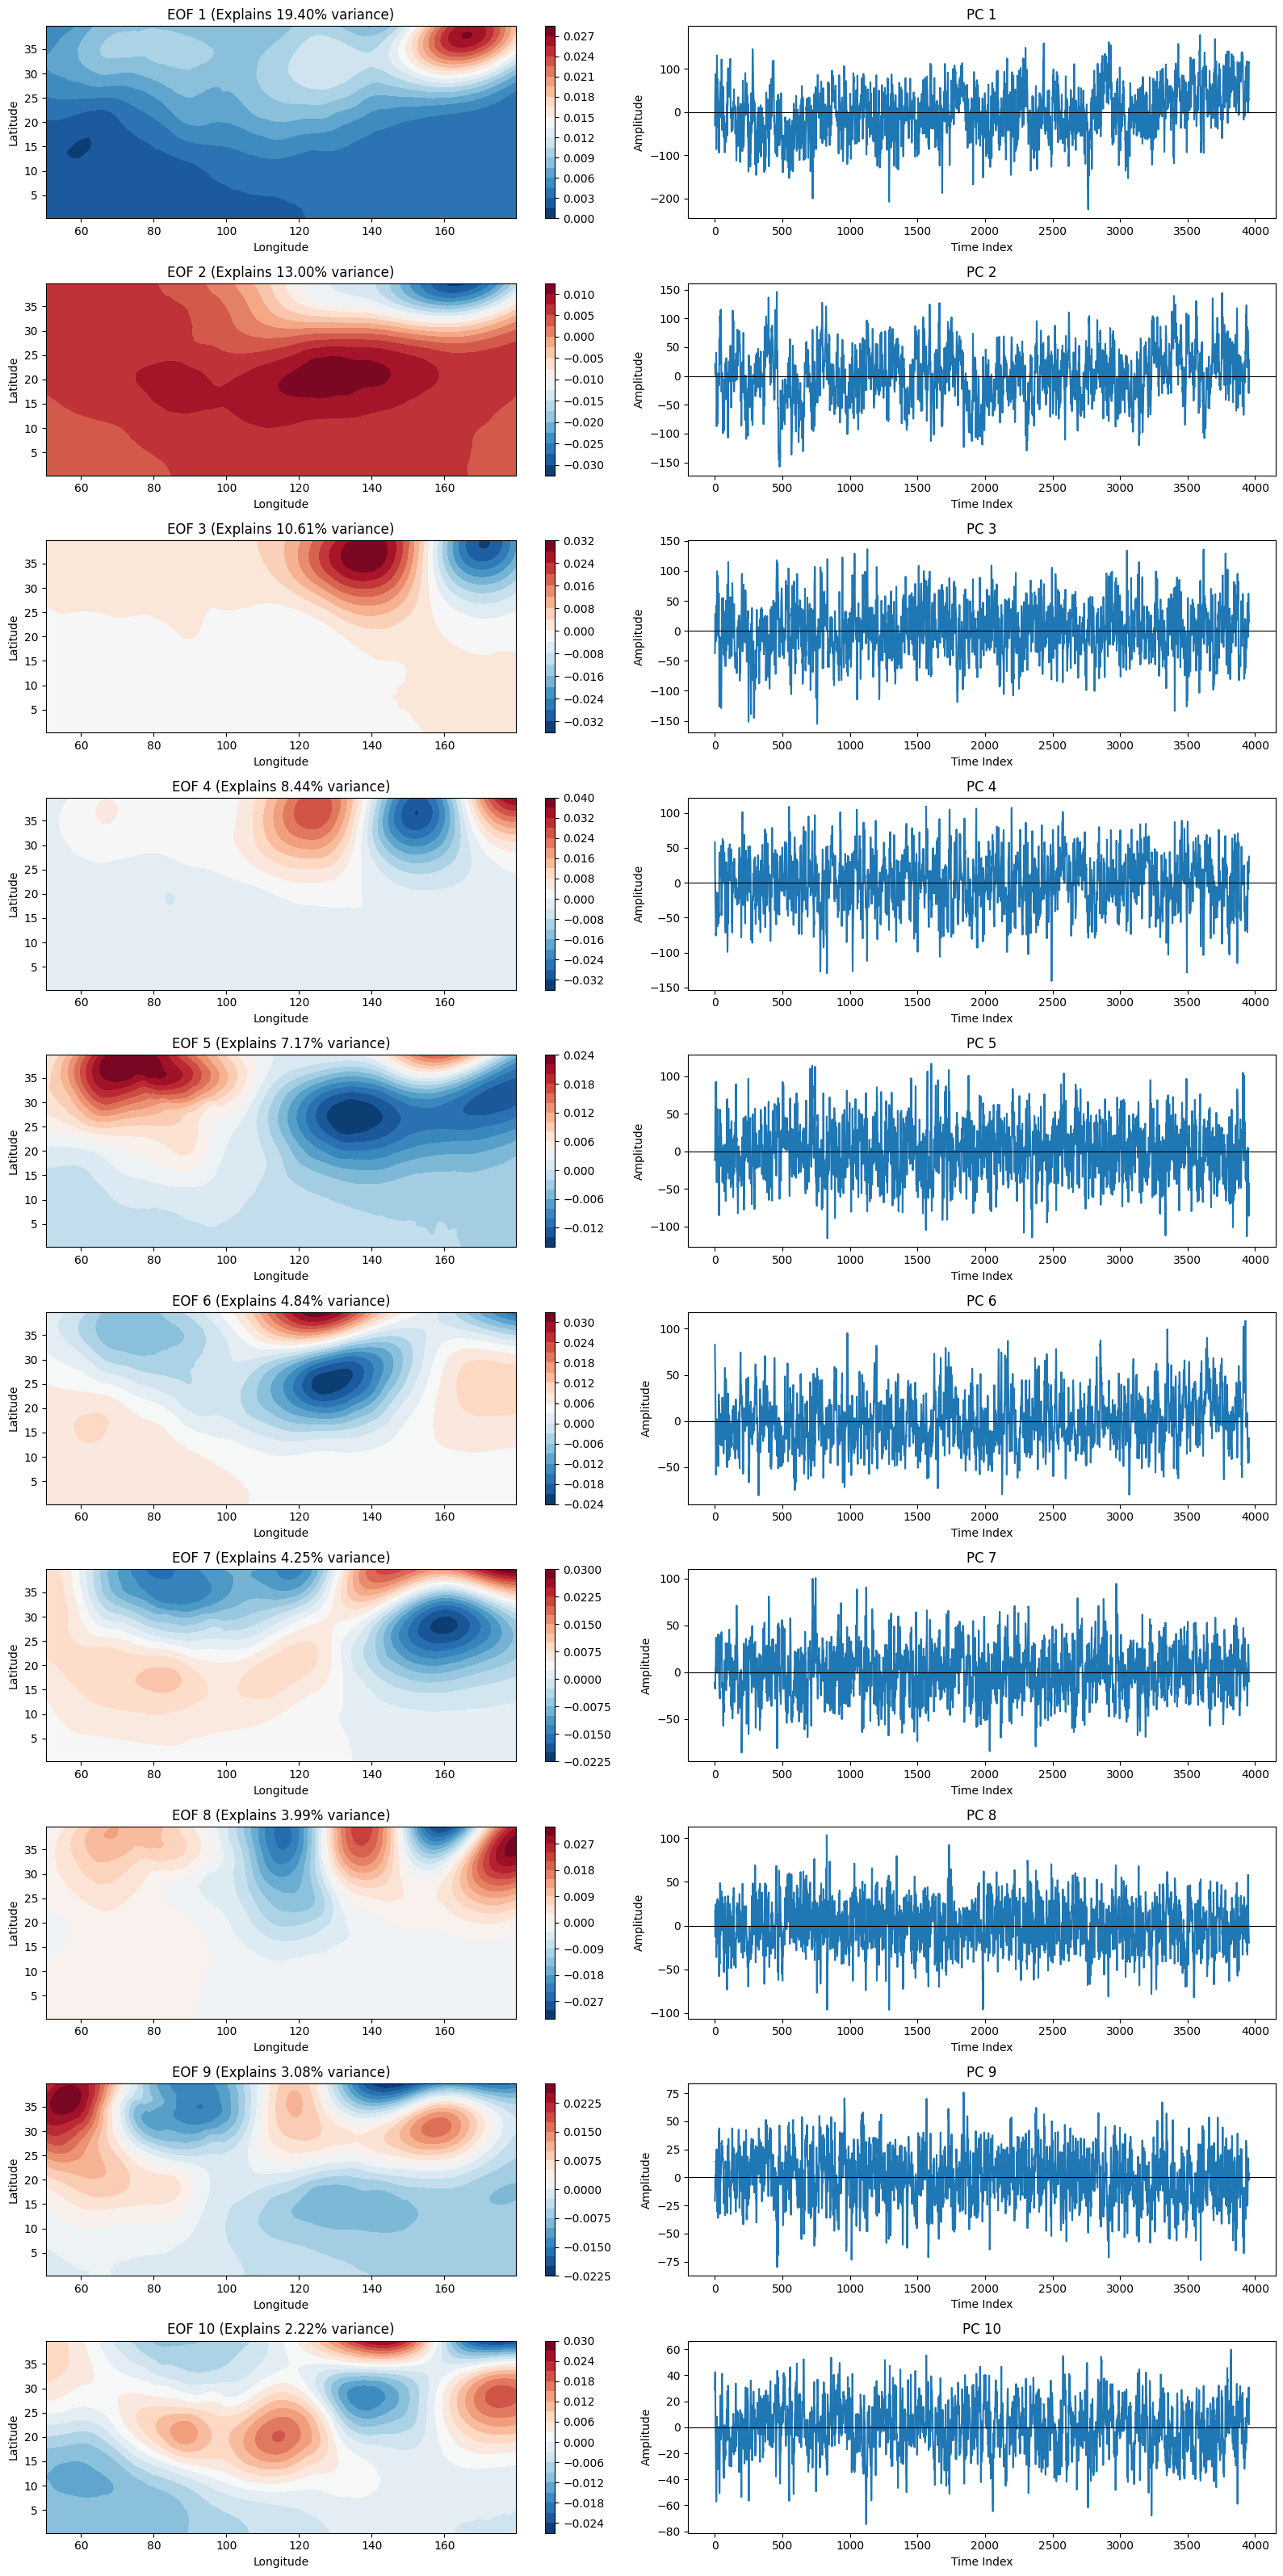

In [39]:
import matplotlib.pyplot as plt

# ==========================================
# 6. 重新 reshape EOF 成 (lat, lon)
# ==========================================
lat_new = ds_subset.lat.values
lon_new = ds_subset.lon.values
nlat = len(lat_new)
nlon = len(lon_new)

# EOFs_sub shape = (10, nlat*nlon)
EOF_maps = EOFs_sub.reshape(n_modes, nlat, nlon)

# 計算EOF解釋變異度
variance_fraction = (s_sub[:n_modes]**2) / np.sum(s_sub**2) * 100

# ==========================================
# 7. 畫前 10 個 EOF + PC
# ==========================================
fig, axes = plt.subplots(n_modes, 2, figsize=(16, 32))
plt.subplots_adjust(hspace=0.4)

for i in range(n_modes):
    # ====== 左欄：EOF ======
    ax1 = axes[i, 0]
    cf = ax1.contourf(lon_new, lat_new, EOF_maps[i], levels=20, cmap='RdBu_r')
    plt.colorbar(cf, ax=ax1, orientation='vertical')
    ax1.set_title(f"EOF {i+1} (Explains {variance_fraction[i]:.2f}% variance)")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")

    # ====== 右欄：PC ======
    ax2 = axes[i, 1]
    ax2.plot(PCs_sub[:, i])
    ax2.axhline(0, color='k', linewidth=0.8)
    ax2.set_title(f"PC {i+1}")
    ax2.set_xlabel("Time Index")
    ax2.set_ylabel("Amplitude")

plt.tight_layout()
plt.savefig("EOF.png")
plt.show()


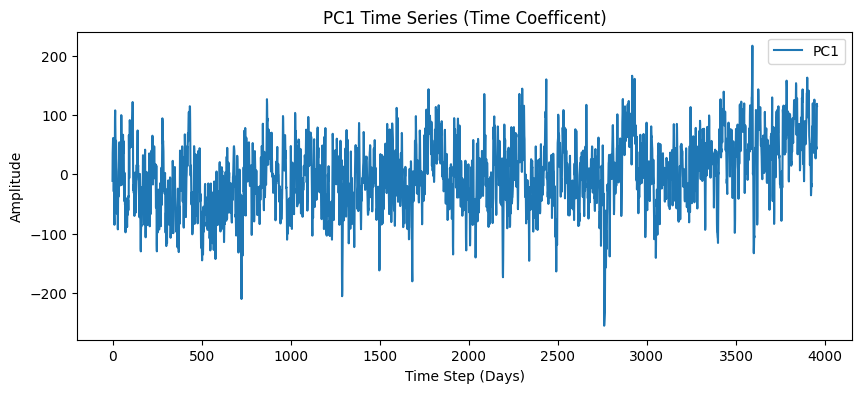

In [28]:
# ==========================================
# 5. 簡單畫個圖確認 PC1
# ==========================================
# 畫出第一個 PC 的時間序列片段，看看是否合理
plt.figure(figsize=(10, 4))
plt.plot(PCs_sub[:, 0], label='PC1')
plt.title('PC1 Time Series (Time Coefficent)')
plt.xlabel('Time Step (Days)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


重建的 Index 與原始 Index 的相關係數: 0.8547


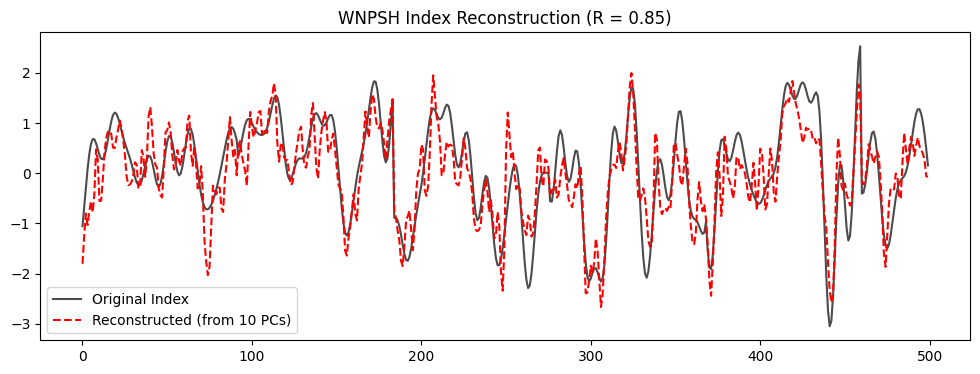

In [40]:

# ==========================================
# 4. 驗證效果 (Reconstruction Check)
# ==========================================
# 讓我們看看這 10 個 PC 能不能還原出原本的 Index
index_reconstructed = np.dot(PCs_sub, a_sub)

# 計算相關係數 (Correlation)
correlation = np.corrcoef(index_jja, index_reconstructed)[0, 1]

print(f"\n重建的 Index 與原始 Index 的相關係數: {correlation:.4f}")

# 畫圖比較一下前 100 天
plt.figure(figsize=(12, 4))
plt.plot(index_jja[:500], label='Original Index', color='black', alpha=0.7)
plt.plot(index_reconstructed[:500], label='Reconstructed (from 10 PCs)', color='red', linestyle='--')
plt.title(f'WNPSH Index Reconstruction (R = {correlation:.2f})')
plt.legend()
plt.savefig("PC_fit_Index.png")
plt.show()

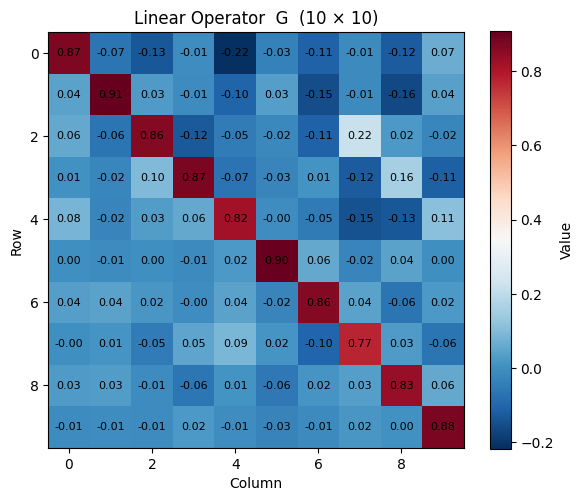

In [43]:
plt.figure(figsize=(6, 5))
plt.imshow(G_sub, cmap='RdBu_r', aspect='equal')
plt.colorbar(label='Value')
plt.title('Linear Operator  G  (10 × 10)')
plt.xlabel('Column')
plt.ylabel('Row')

# 在每個格子上標上數值（可選）
for i in range(G_sub.shape[0]):
    for j in range(G_sub.shape[1]):
        plt.text(j, i, f"{G_sub[i, j]:.2f}",
                 ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.savefig("G.png")
plt.show()


<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:64: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PDK\AppData\Local\Temp\ipykernel_21432\3390819571.py:64: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Max Variance Growth ($\lambda_{max}$ of $M$)', fontsize=12)


開始計算瞬變增長 (Transient Growth), Lag 1 to 15 days...

[結果分析]
最大瞬變增長發生在 Lag = 1 天
最大放大倍率 (Growth Factor): 0.00


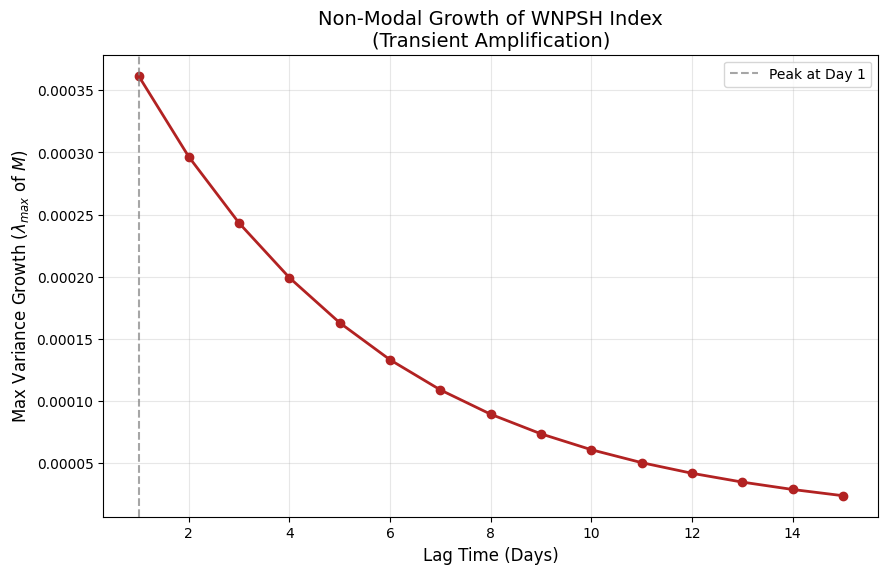

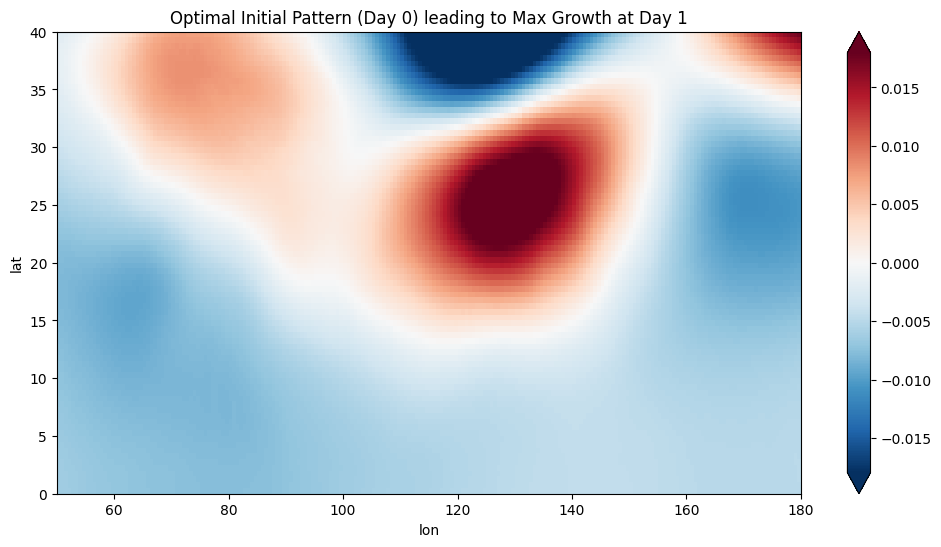

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 設定我們想要觀察的天數範圍 (Lag tau)
max_lag = 15
lags = np.arange(1, max_lag + 1)

# 儲存每個 lag 的最大增長率
growth_rates = []
# 儲存最佳模式的特徵向量 (為了後續畫圖用)
optimal_patterns = []

# 使用我們修正後的算子 G_sub 和 投影矩陣 rho_sub
G_use = G_sub
rho_use = rho_sub

print(f"開始計算瞬變增長 (Transient Growth), Lag 1 to {max_lag} days...")

for tau in lags:
    # 1. 計算 G 的 tau 次方 (G^tau)
    # np.linalg.matrix_power 可以快速計算矩陣次方
    G_tau = np.linalg.matrix_power(G_use, tau)
    
    # 2. 計算 M 矩陣
    # 公式: M = rho * G^tau * (G^tau)^T * rho^T
    # 分步計算比較清楚：
    # A = rho * G^tau
    A = np.dot(rho_use, G_tau)
    # M = A * A^T
    M = np.dot(A, A.T)
    
    # 3. 解特徵值與特徵向量
    # eigh 適用於對稱矩陣 (Symmetric / Hermitian)，計算更穩更快
    eigvals, eigvecs = np.linalg.eigh(M)
    
    # 4. 提取最大特徵值 (及其對應的向量)
    # np.linalg.eigh 回傳的特徵值是由小到大排列的，所以最後一個是最大的
    max_lambda = eigvals[-1]
    leading_vec = eigvecs[:, -1]
    
    growth_rates.append(max_lambda)
    optimal_patterns.append(leading_vec)

# 轉換成 numpy array 方便畫圖
growth_rates = np.array(growth_rates)

# ==========================================
# 視覺化 1: 增長曲線 (Growth Curve)
# ==========================================
print("\n[結果分析]")
# 找出峰值發生的時間
peak_idx = np.argmax(growth_rates)
peak_lag = lags[peak_idx]
peak_val = growth_rates[peak_idx]

print(f"最大瞬變增長發生在 Lag = {peak_lag} 天")
print(f"最大放大倍率 (Growth Factor): {peak_val:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(lags, growth_rates, marker='o', linewidth=2, color='firebrick')
plt.axvline(x=peak_lag, color='gray', linestyle='--', alpha=0.7, label=f'Peak at Day {peak_lag}')
plt.title('Non-Modal Growth of WNPSH Index\n(Transient Amplification)', fontsize=14)
plt.xlabel('Lag Time (Days)', fontsize=12)
plt.ylabel('Max Variance Growth ($\lambda_{max}$ of $M$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ==========================================
# 視覺化 2: 最佳初始型態 (Optimal Pattern) 的空間分佈
# ==========================================
# 我們取出峰值時刻對應的那個特徵向量
# 這個向量是在 "PC 空間" 的權重組合
optimal_pc_weights = optimal_patterns[peak_idx]

# 將 PC 權重映射回實際空間地圖 (EOF 空間)
# Map = sum( weight_i * EOF_i )
# EOFs_sub shape: (10, space_points)
# optimal_pc_weights shape: (10,)
optimal_map_flat = np.dot(optimal_pc_weights, EOFs_sub)

# 我們需要把展平的 (space_points,) 還原回 (lat, lon)
# 這需要利用我們之前存下來的 ds_subset 資訊
# 創建一個空的 array，填入 NaN (為了處理海陸遮罩或之前 dropna 掉的點，雖然這裡應該全是滿的)
# 比較簡單的方法是用 xarray 的 copy
optimal_da = ds_subset['z'].isel(time=0).copy() # 借用一個時間點的殼
# 將數值填入 (注意：如果之前 dropna 導致點數變少，這裡要小心對齊)
# 比較安全的做法是建立一個與 stack 後 coordinates 一致的 series
import pandas as pd

# 之前 stack 的坐標
coords_stacked = ds_subset['z'].stack(location=('lat', 'lon')).dropna(dim='location', how='any').coords['location']

# 建立 DataArray
da_flat = xr.DataArray(optimal_map_flat, coords={'location': coords_stacked}, dims='location')
# Unstack 回 (lat, lon)
optimal_map_2d = da_flat.unstack('location')

plt.figure(figsize=(12, 6))
optimal_map_2d.plot(cmap='RdBu_r', robust=True)
plt.title(f'Optimal Initial Pattern (Day 0) leading to Max Growth at Day {peak_lag}')
plt.show()

<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
C:\Users\PDK\AppData\Local\Temp\ipykernel_21432\1620934311.py:66: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Growth Factor (Singular Value $\sigma_1$)', fontsize=12)


開始分析瞬變增長 (SVD Method), Lag 1 to 15 days...

[分析結果]
最大瞬變增長發生在 Lag = 1 天
最大奇異值 (Singular Value): 1.9020e-02
注意：這個數值代表 '單位 PC 擾動' 能造成多大的 'Index 變化'。
由於 PC 單位很大(位勢)，Index 單位很小(標準化)，數值很小是正常的。
重點在於曲線的形狀：是否先上升後下降？


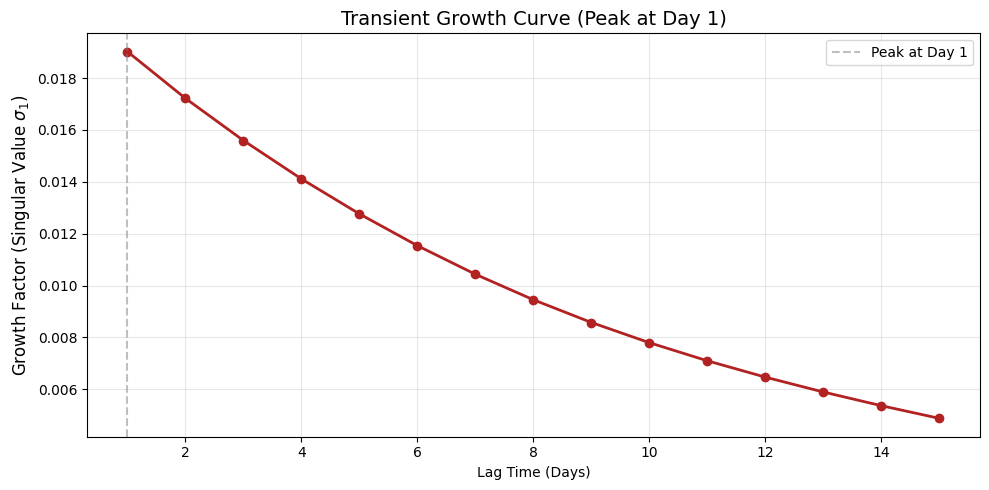

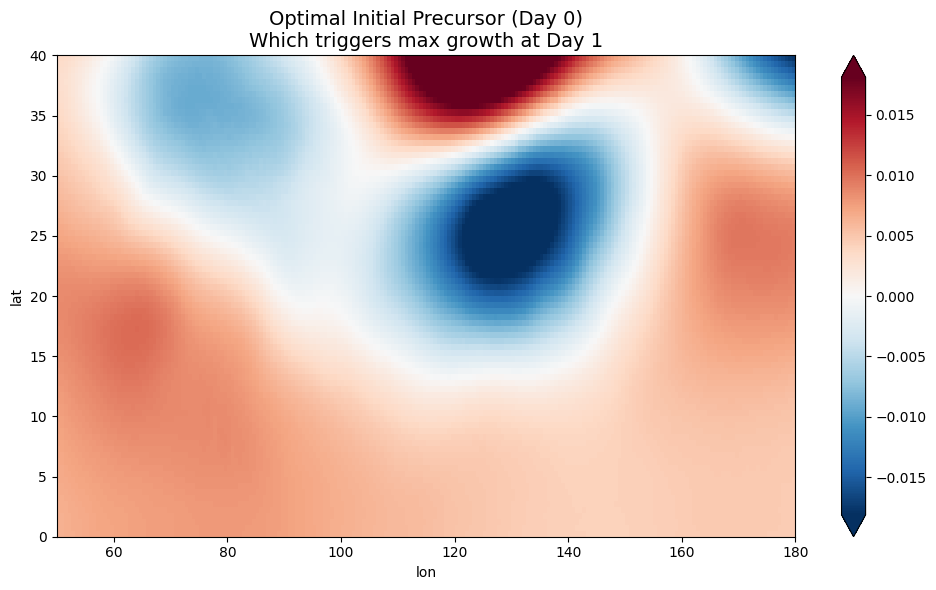

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 設定 Lag 範圍
max_lag = 15
lags = np.arange(1, max_lag + 1)

growth_factors = []     # 存成長率
optimal_initials = []   # 存最佳初始擾動 (V) - 這是你想看的 "n天前"
evolved_structures = [] # 存演變後結構 (U) - 這是作業公式算出的 "n天後"

# 定義算子成分
G_use = G_sub
rho_use = rho_sub


print(f"開始分析瞬變增長 (SVD Method), Lag 1 to {max_lag} days...")

for tau in lags:
    # 1. 計算 G 的 tau 次方
    G_tau = np.linalg.matrix_power(G_use, tau)
    
    # 2. 組合總算子 L = rho * G^tau
    # 這個算子 L 代表：給定一個初始 PC 狀態 x(0)，算出 τ 天後的 Index 貢獻量
    L = np.dot(rho_use, G_tau)
    
    # 3. 使用 SVD 取代特徵值分解
    # L = U * S * Vt
    # S (Singular Values) 的平方就是 M 的特徵值 (Eigenvalues)
    # 這樣我們可以一次拿到所有資訊
    U, s, Vt = np.linalg.svd(L)
    
    # 4. 提取最大增長模態 (First mode)
    # s[0] 是最大的奇異值，代表最大放大倍率
    # Vt[0, :] 是對應的 "右奇異向量" (最佳初始 PC 分布)
    
    growth_factors.append(s[0])
    optimal_initials.append(Vt[0, :])
    evolved_structures.append(U[:, 0]) # 雖然 U 對應的是 Index 空間權重，但在這裡 rho 是對角矩陣，意義類似

growth_factors = np.array(growth_factors)

# ==========================================
# 結果分析 1: 成長曲線 (數值與形狀)
# ==========================================
# 找出峰值
peak_idx = np.argmax(growth_factors)
peak_lag = lags[peak_idx]
peak_val = growth_factors[peak_idx]

print("\n[分析結果]")
print(f"最大瞬變增長發生在 Lag = {peak_lag} 天")
print(f"最大奇異值 (Singular Value): {peak_val:.4e}") # 使用科學記號查看
print("注意：這個數值代表 '單位 PC 擾動' 能造成多大的 'Index 變化'。")
print("由於 PC 單位很大(位勢)，Index 單位很小(標準化)，數值很小是正常的。")
print("重點在於曲線的形狀：是否先上升後下降？")

# 歸一化曲線以便觀察形狀 (Normalize to initial value)
# 假設 Lag=0 (即 tau=0) 時，L = rho，增長為 rho 的最大奇異值
# 這裡我們簡單除以第一天的值來觀察相對趨勢，或者直接畫原始值
plt.figure(figsize=(10, 5))
plt.plot(lags, growth_factors, marker='o', color='firebrick', linewidth=2)
plt.axvline(x=peak_lag, color='gray', linestyle='--', alpha=0.5, label=f'Peak at Day {peak_lag}')
plt.title(f'Transient Growth Curve (Peak at Day {peak_lag})', fontsize=14)
plt.xlabel('Lag Time (Days)')
plt.ylabel('Growth Factor (Singular Value $\sigma_1$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("growth_rate.png")
plt.show()

# ==========================================
# 結果分析 2: 畫出那個導致最大增長的 "前兆" (Precursor)
# ==========================================
# 這就是老師說的：n 天前長什麼樣子，會導致 n 天後副高最強
optimal_pc_pattern = optimal_initials[peak_idx]

# 映射回空間圖
optimal_map_flat = np.dot(optimal_pc_pattern, EOFs_sub)

# 轉回 (lat, lon)
# 借用之前的 DataArray 結構來還原座標
import xarray as xr
coords_stacked = ds_subset['z'].stack(location=('lat', 'lon')).dropna(dim='location', how='any').coords['location']
da_flat = xr.DataArray(optimal_map_flat, coords={'location': coords_stacked}, dims='location')
optimal_map_2d = da_flat.unstack('location')

plt.figure(figsize=(10, 6))
# 這裡畫的是 Anomaly，紅正藍負
optimal_map_2d.plot(cmap='RdBu_r', robust=True)
plt.title(f'Optimal Initial Precursor (Day 0)\nWhich triggers max growth at Day {peak_lag}', fontsize=14)
plt.tight_layout()
plt.savefig("most_unstable_mode.png")
plt.show()

# 時間濾波